# Template for analyzing the CLM5-PPE
- Updated Jan 27, 2023
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import seaborn as sns

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("/glade/u/home/djk2120/ppe_tools")
from ppe_analysis.analysis import *

In [3]:
import panel as pn
import param
pn.extension()

## spin up some extra cores on CASPER

In [21]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='00:30:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35818 instead
  f"Port {expected} is already in use.\n"


In [22]:
client.cluster

In [6]:
def clear_files():
    files=glob.glob('../data/*.nc')
    dvs=np.unique([file.split('/')[-1].split('.')[0].split('0')[0] for file in files])
    for dv in dvs:
        files=sorted(glob.glob('../data/'+dv+'*.nc'))
        if len(files)>1:
            cmd='mv '+files[-1]+' tmp.nc'    
            os.system(cmd)
            cmd='rm ../data/'+dv+'*.nc'
            os.system(cmd)
            cmd='mv tmp.nc '+'../data/'+dv+'.nc'
            os.system(cmd)

In [7]:
def postp(v,g,dsets,cfs):

    exps=[exp for exp in dsets]
    ds=dsets[exps[0]]
    group={'glob':[],'biome':ds.biome,'pft':ds.pft}
    gstr={'glob':'Global','biome':'Biome','pft':'PFT'}
    cf2={'mean':cfs[v]['cf2'],'iav':None,'amp':None}
    u={'mean':cfs[v]['u3'],'iav':cfs[v]['u2'],'amp':cfs[v]['u1']}  
    if g=='pft': la=ds.lapft 
    else:        la=ds.la

    files=sorted(glob.glob('../data/'+v+'*.nc'))

    if files:
        f0=files[-1]
        i=f0.split(v)[1].split('.')[0]
        if i=='': i=0
        else: i=int(i)
        f1='../data/'+v+str(i+1).zfill(3)+'.nc'
        out=xr.open_dataset(f0)  

    else:
        f1='../data/'+v+'.nc'
        out=xr.Dataset()
        out['exp']=exps
        for k in ['key','param','minmax']:
            out[k]=ds[k]

    xanns=[]
    write=False
    for op in ['mean','iav','amp']:
        m=v+'_'+g+'_'+op
        if m not in out:
            write=True
            print(m)
            if (op=='mean')|(op=='iav'):
                if (op=='mean')|(len(xanns)==0):
                    xanns=[amean(dsets[exp][v],cf=cfs[v]['cf1']) for exp in exps]

            if op=='mean':   
                xs=[xann.mean(dim='year') for xann in xanns]
            elif op=='iav':
                xs=[xann.std(dim='year') for xann in xanns]
            elif op=='amp':
                cf1=cfs[v]['cf1']
                if not cf1:
                    cf1=1
                xms=[cf1*dsets[exp][v].groupby('time.month').mean().compute() for exp in exps]
                xs=[xm.max(dim='month')-xm.min(dim='month') for xm in xms]


            xouts=[gmean(x,la,g=group[g],cf=cf2[op]) for x in xs]
            out[m]=xr.concat(xouts,dim='exp')
            out[m].attrs={'units':u[op]}

    out['exp']=exps
    if 'group' in out:
        out=out.drop('group')

    if write:
        out.to_netcdf(f1)

In [25]:
dvs=['AR']
exps=['CTL2010','C285','C867','AF1855','AF2095','NDEP']
dsets = {exp:get_exp(exp,dvs=dvs) for exp in exps}
ds=dsets['CTL2010']

In [29]:
cfs['AR'] ={'cf1': 24*60*60, 'cf2': 1e-9,'u1':'gC/m2/d','u2':'gC/m2/yr','u3':'PgC/yr'}

In [27]:
cfs={dv:{'cf1':None,'cf2':None,'u1':ds[dv].attrs['units'],'u2':ds[dv].attrs['units'],'u3':ds[dv].attrs['units']} for dv in dvs}

In [26]:
for dv in ['TOTVEGC','TOTSOMC_1m']:
    cfs[dv]={'cf1': None, 'cf2': 1e-9,'u1':ds[dv].attrs['units'],'u2':ds[dv].attrs['units'],'u3':'PgC'}

KeyError: 'TOTVEGC'

In [31]:
5+5

10

In [32]:
postp('AR','glob',dsets,cfs)

In [24]:
postp('TOTSOMC_1m','glob',dsets,cfs)

TOTSOMC_1m_glob_mean
TOTSOMC_1m_glob_iav
TOTSOMC_1m_glob_amp


In [203]:
clear_files()

In [199]:

dvs=['HR','TWS']


In [202]:
for v in dvs:
    postp(v,'glob',dsets,cfs)
    postp(v,'biome',dsets,cfs)

HR_glob_mean
HR_glob_iav
HR_glob_amp
HR_biome_mean
HR_biome_iav
HR_biome_amp
TWS_glob_mean
TWS_glob_iav
TWS_glob_amp
TWS_biome_mean
TWS_biome_iav
TWS_biome_amp


In [201]:
ds=dsets['CTL2010']
cfs={dv:{'cf1':None,'cf2':None,'u1':ds[dv].attrs['units'],'u2':ds[dv].attrs['units'],'u3':ds[dv].attrs['units']} for dv in dvs}
cfs['GPP']={'cf1': 24*60*60, 'cf2': 1e-9,'u1':'gC/m2/d','u2':'gC/m2/yr','u3':'PgC/yr'}
cfs['NPP']={'cf1': 24*60*60, 'cf2': 1e-9,'u1':'gC/m2/d','u2':'gC/m2/yr','u3':'PgC/yr'}
cfs['NBP']={'cf1': 24*60*60, 'cf2': 1e-9,'u1':'gC/m2/d','u2':'gC/m2/yr','u3':'PgC/yr'}
cfs['ER'] ={'cf1': 24*60*60, 'cf2': 1e-9,'u1':'gC/m2/d','u2':'gC/m2/yr','u3':'PgC/yr'}
cfs['HR'] ={'cf1': 24*60*60, 'cf2': 1e-9,'u1':'gC/m2/d','u2':'gC/m2/yr','u3':'PgC/yr'}
cfs['COL_FIRE_CLOSS']={'cf1': 24*60*60, 'cf2': 1e-9,'u1':'gC/m2/d','u2':'gC/m2/yr','u3':'PgC/yr'}

cfs['QRUNOFF']={'cf1': 24*60*60,'cf2':None,'u1':'mm/d','u2':'mm/yr','u3':'mm/yr'}

In [9]:
postp('TLAI','glob',dsets,cfs)

TLAI_glob_mean
TLAI_glob_iav
TLAI_glob_amp


In [210]:
vv=('NPP','GPP')
xs= [xr.open_dataset('../data/'+v+'.nc')[v+'_glob_mean'] for v in vv]
x=xs[0]/xs[1]

In [220]:
def get_x(v,d='glob',op='mean'):
    if v=='CUE':
        v=('NPP','GPP')
    if type(v) is str:
        x=xr.open_dataset('../data/'+v+'.nc')[v+'_'+d+'_'+op]
    else:
        xs= [xr.open_dataset('../data/'+vv+'.nc')[vv+'_glob_mean'] for vv in v]
        x=xs[0]/xs[1]
        
        
    return x

In [ ]:
x=xr.open_dataset

Text(0.5, 0, 'Forcing Scenario')

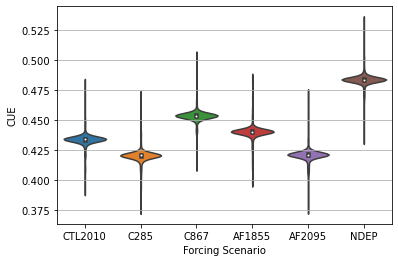

In [211]:
v='CUE'
x[4,58]=np.nan
nens=len(x.ens)

df=pd.DataFrame({v:np.concatenate([x for x in x]),
                 'Experiment':np.repeat(exps,nens)})

sns.violinplot(data=df,x='Experiment',y=v,orient='v')

plt.grid(axis='y')
plt.xlabel('Forcing Scenario')


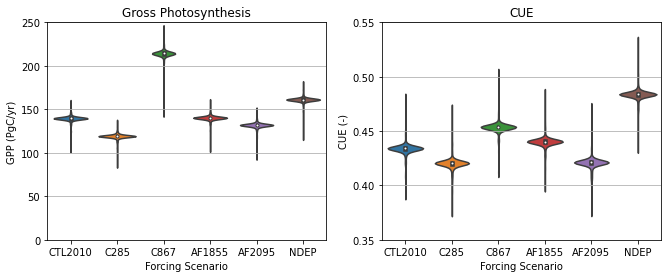

In [230]:
plt.figure(figsize=[11,4])
tts=['Gross Photosynthesis','CUE']
for i,v in enumerate(['GPP','CUE']):
    plt.subplot(1,2,i+1)
    x=get_x(v)
    x[4,58]=np.nan
    nens=len(x.ens)

    df=pd.DataFrame({v:np.concatenate([x for x in x]),
                     'Experiment':np.repeat(exps,nens)})

    sns.violinplot(data=df,x='Experiment',y=v,orient='v')
    if i==0:
        plt.ylim([0,250])
        plt.ylabel('GPP (PgC/yr)')
    else:
        plt.ylim([0.35,0.55])
        plt.ylabel('CUE (-)')
        plt.yticks(0.35+0.05*np.arange(5))
    plt.grid(axis='y')


    plt.xlabel('Forcing Scenario')
    plt.title(tts[i])
    
    plt.savefig('../figs/violins.pdf',bbox_inches='tight')

Text(0.5, 0, 'Forcing Scenario')

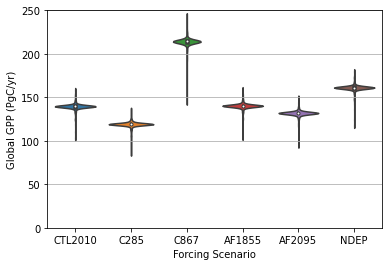

In [27]:
ds0=dsets['CTL2010']

In [12]:
ds=xr.open_dataset('../data/TLAI001.nc')

In [16]:
x=ds.TLAI_glob_mean.sel(exp='CTL2010')
xb=ds.TLAI_biome_mean.sel(exp='CTL2010')

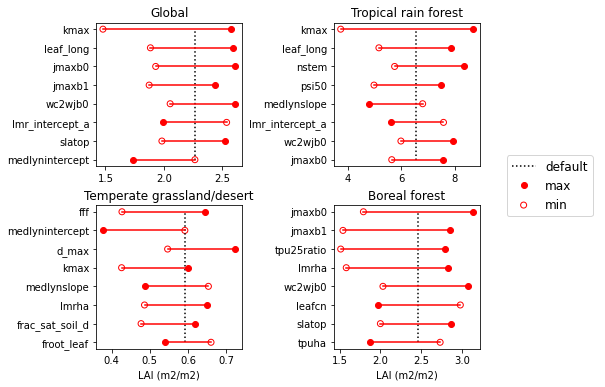

In [76]:
fig,axs=plt.subplot_mosaic('AXBF;AXBE;GXHE;CXDE;CXDI',
                           figsize=[9,6],
                           gridspec_kw={'width_ratios': [3,1,3,2],'height_ratios': [3, 1,0.5,1,3]})
for s in 'XEFGHI':
    axs[s].axis('off')
    
rank_plot(x,ds,8,ax=axs['A'])
axs['A'].set_title('Global')

for b,s in zip([1,7,8],'BCD'):
    rank_plot(xb.sel(biome=b),ds,8,ax=axs[s])
    axs[s].set_title(ds0.biome_name[b].values)
    if b>1:
        axs[s].set_xlabel('LAI (m2/m2)')
    
#legend
rank_plot(x,ds,8,axs['E'])
axs['E'].set_xlim([-3,-2])
axs['E'].legend(loc=5,fontsize=12);

plt.savefig('../figs/lai_biome.pdf',bbox_inches='tight')


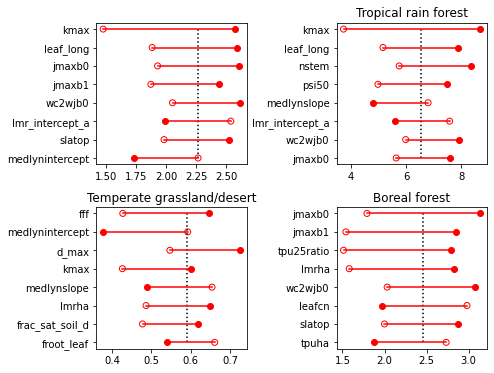

In [34]:
fig=plt.figure(figsize=[7,6])
ax=fig.add_subplot(221)


for i,b in enumerate([1,7,8]):
    ax=fig.add_subplot(2,2,i+2)
    rank_plot(xb.sel(biome=b),ds,8,ax=ax)
    ax.set_title(ds0.biome_name[b].values)





fig.subplots_adjust(wspace=0.6,hspace=0.3)


### OAAT: monthly h0 data

In [355]:
exps=['CTL2010','C285','C867','AF1855','AF2095','NDEP']
dvs=['TLAI','GPP','FCTR','TWS','EFLX_LH_TOT','SOILWATER_10CM','NBP','QRUNOFF']
dsets = {exp:get_exp(exp,dvs=dvs) for exp in exps}

In [356]:
ds=dsets['CTL2010']

In [415]:
cfs={dv:{'cf1':None,'cf2':None} for dv in dvs}
cfs['GPP']={'cf1': 24*60*60, 'cf2': 1e-9}
cfs['NBP']={'cf1': 24*60*60, 'cf2': 1e-9}
cfs['QRUNOFF']={'cf1':24*60*60/365, 'cf2':None}

In [358]:
x={v:{exp:
      gmean(amean(dsets[exp][v],cf=cfs[v]['cf1']),ds.la,cf=cfs[v]['cf2']) 
      for exp in exps} 
      for v in dvs}

In [359]:
for v in dvs:
    x[v]['AF2095'][58,:]=np.nan

In [362]:
v='NBP'
e=np.tile(exps,[373,1]).T.ravel()
xv=np.concatenate([x[v][exp].mean(dim='year') for exp in exps])
df=pd.DataFrame({v:xv,'exp':e})

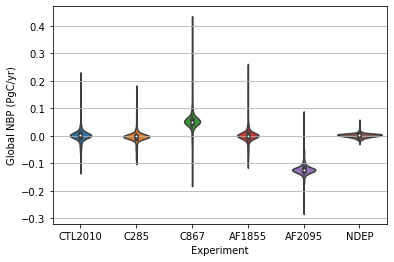

In [367]:
sns.violinplot(data=df,x='exp',y='NBP',orient='v')
plt.grid(axis='y')
plt.ylabel('Global NBP (PgC/yr)')
plt.xlabel('Experiment');

In [418]:
v='GPP'
e=np.tile(exps,[373,1]).T.ravel()
xv=np.concatenate([x[v][exp].mean(dim='year') for exp in exps])
df=pd.DataFrame({v:xv,'exp':e})

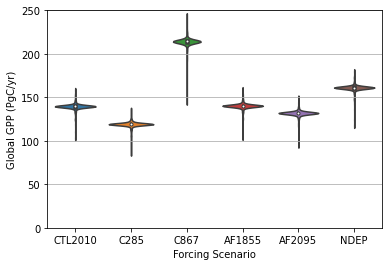

In [419]:
sns.violinplot(data=df,x='exp',y='GPP',orient='v')
plt.ylim([0,250])
plt.grid(axis='y')
plt.ylabel('Global GPP (PgC/yr)')
plt.xlabel('Forcing Scenario')
plt.savefig('../figs/gpp_violin.pdf',bbox_inches='tight');

In [135]:
for exp in exps:
    print(exp.ljust(9),int(np.round((x['GPP'][exp].max()-x['GPP'][exp].min()).values)))

CTL2010   60
C285      54
C867      108
AF1855    60
AF2095    60
NDEP      69


In [138]:
np.mean( x['GPP']['C867'].mean(dim='year')/x['GPP']['CTL2010'].mean(dim='year'))

<xarray.DataArray 'GPP' ()>
array(1.53302198)
Coordinates:
    group    <U6 'global'

In [143]:
np.mean( x['GPP']['CTL2010'].mean(dim='year')/x['GPP']['C285'].mean(dim='year'))

<xarray.DataArray 'GPP' ()>
array(1.17230363)
Coordinates:
    group    <U6 'global'

In [146]:
xx=x['GPP']['CTL2010'].mean(dim='year')

In [152]:
(abs(xx-xx.isel(ens=0))<2).sum()/373

<xarray.DataArray 'GPP' ()>
array(0.81233244)
Coordinates:
    group    <U6 'global'

In [271]:
exp='CTL2010'
v='TLAI'
cf1=cfs[v]['cf1']
cf2=cfs[v]['cf2']
lai=gmean(amean(dsets[exp][v],cf1),ds.la,g=ds.biome,cf=cf2).mean(dim='year')

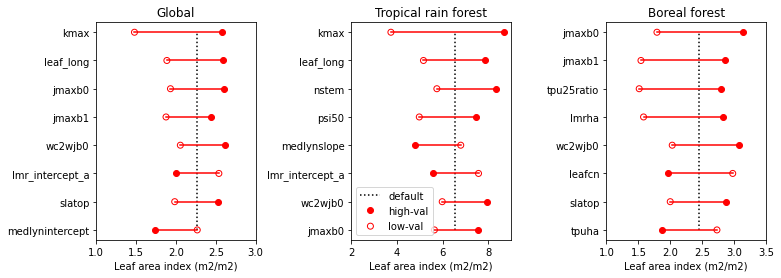

In [330]:
fig=plt.figure(figsize=[12,4])
for b in [0,1,8]:
    ax=fig.add_subplot(1,3,1+b-6*(b==8))
    
    if b>0:
        rank_plot(lai.isel(biome=b),ds,8,ax=ax)
        plt.title(ds.biome_name[b].values)
        if b==1:
            plt.xlim([2,9])
            plt.legend(loc=3)
        else:
            plt.xlim([1,3.5])
    else:
        rank_plot(x['TLAI']['CTL2010'].mean(dim='year'),ds,8,ax=ax)
        plt.title('Global')
        plt.xlim([1,3])

    plt.xlabel('Leaf area index (m2/m2)')

plt.subplots_adjust(wspace=0.6)
plt.savefig('../figs/lai_biome.pdf',bbox_inches='tight')

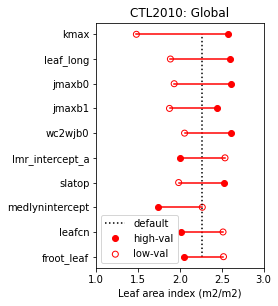

In [320]:
fig=plt.figure(figsize=[3,4.5])
ax=fig.add_subplot(111)
rank_plot(x['TLAI']['CTL2010'].mean(dim='year'),ds,10,ax=ax)
plt.title('CTL2010: Global')
plt.xlabel('Leaf area index (m2/m2)')
plt.xlim([1,3])
plt.legend(loc=3);

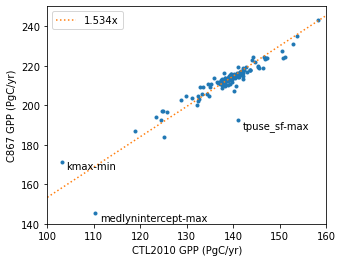

In [423]:
x1=x['GPP']['CTL2010'].mean(dim='year')
x2=x['GPP']['C867'].mean(dim='year')
fert=(x2.isel(ens=0)/x1.isel(ens=0)).values
xv=np.array([100,160])

plt.figure(figsize=[5,4])
plt.plot(x1,x2,'.',label=None)
plt.plot(xv,fert*xv,':',label=str(np.round(fert,3))+'x')
plt.legend()
plt.xlim([100,160])
plt.ylim([140,250])
plt.xlabel('CTL2010 GPP (PgC/yr)')
plt.ylabel('C867 GPP (PgC/yr)');


outliers=abs(x2-x1*fert).argsort()[-3:]
for ee in outliers:
    p=str(dsets['CTL2010'].param[ee].values)+'-'+str(dsets['CTL2010'].minmax[ee].values)
    plt.text(x1.isel(ens=ee)+1,x2.isel(ens=ee)-4,p)

plt.savefig('../figs/co2fert.pdf',bbox_inches='tight')

In [414]:
dsets['CTL2010']['QRUNOFF'].isel(ens=0)

<xarray.DataArray 'QRUNOFF' (time: 120, gridcell: 400)>
dask.array<getitem, shape=(120, 400), dtype=float32, chunksize=(120, 400), chunktype=numpy.ndarray>
Coordinates:
  * gridcell  (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * time      (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Attributes:
    long_name:     total liquid runoff not including correction for land use ...
    units:         mm/s
    cell_methods:  time: mean

In [413]:
amean(dsets['CTL2010']['QRUNOFF'].isel(ens=0),cf=cfs['QRUNOFF']['cf1'])

<xarray.DataArray 'QRUNOFF' (year: 10, gridcell: 400)>
array([[ 330.91557624, 2326.2689396 ,  323.43658946, ...,  241.17337141,
         403.93820617,  272.46037498],
       [ 437.02938353, 2364.37438068,  289.80818756, ...,  232.53243504,
         432.0673604 ,  521.24150904],
       [ 652.7106112 , 2634.74517956,  285.39665627, ...,  179.20435655,
         330.15292182,  480.605551  ],
       ...,
       [ 347.95483995, 2454.82919817,  199.57242565, ...,  259.31115828,
         966.52359168,  327.34875066],
       [ 215.74239286, 2847.59446668,  367.98774247, ...,  320.95491825,
        1262.75686521,  366.52164924],
       [ 472.06153054, 2187.31182801,  425.10152402, ...,  166.88487459,
         181.03491729,  209.98129832]])
Coordinates:
  * gridcell  (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * year      (year) int64 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014

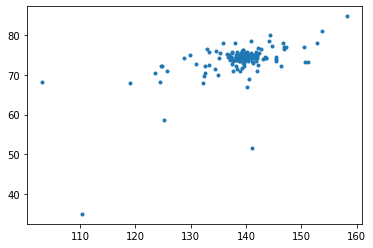

In [236]:
plt.plot(x1,x2-x1,'.')

In [235]:
x1.isel(ens=0)

<xarray.DataArray 'GPP' ()>
array(139.67581136)
Coordinates:
    group    <U6 'global'

In [245]:
ee=f.argsort()[0]
print(ds.param[ee].values,ds.minmax[ee].values,np.round( f[ee].values,3))

medlynintercept max 1.318


In [246]:
ee=f.argsort()[-1]
print(ds.param[ee].values,ds.minmax[ee].values,np.round( f[ee].values,3))

kmax min 1.662


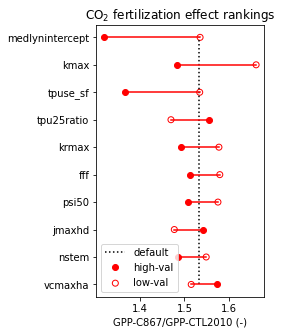

In [234]:
fig=plt.figure(figsize=[3,5])
ax=fig.add_subplot(111)
rank_plot(x2/x1,ds,10,ax=ax)
plt.legend()
plt.xlabel('GPP-C867/GPP-CTL2010 (-)')
plt.title(r'CO$_2$ fertilization effect rankings');
plt.savefig('../figs/supp/co2fert_rankings.pdf',bbox_inches='tight')

In [195]:
f=x2/x1
ggs=['greater','less']
for gg in [0,1]:
    fg = 1-gg
    if gg:
        ix=x1>x1.isel(ens=0)
    else:
        ix=x1<x1.isel(ens=0)
    if fg:
        nn=str(int(np.round(100*(f[ix]>f[0]).sum()/ix.sum()).values))
    else:
        nn=str(int(np.round(100*(f[ix]<f[0]).sum()/ix.sum()).values))

    print(nn+'% of members with CTL2010 GPP '+ggs[gg]+' than default have '+ggs[fg]+' fertilization than the default case')

75% of members with CTL2010 GPP greater than default have less fertilization than the default case
74% of members with CTL2010 GPP less than default have greater fertilization than the default case


In [370]:
help(find_pair)

Help on function find_pair in module ppe_analysis.analysis:

find_pair(da, params, minmax, p)
    returns a subset of da, corresponding to parameter-p
        the returned pair corresponds to [p_min,p_max]



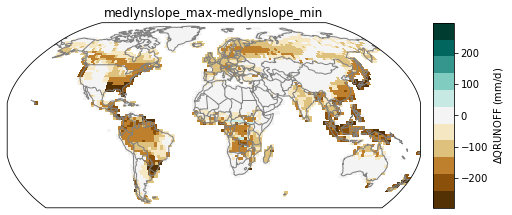

In [409]:
exp='CTL2010'
v='QRUNOFF'
p='medlynslope'
deltmap(exp,v,p)

In [398]:
import panel as pn
import param
pn.extension()

In [404]:
class Selections(param.Parameterized):
    dataVar   = param.Selector(objects=dvs)
    parameter = param.Selector(objects=list(np.unique(ds.param[1:])))
    forcing   = param.Selector(objects=exps)

    def view(self):
        return deltmap(self.forcing,self.dataVar,self.parameter)

obj = Selections()
obj

Selections(dataVar='TLAI', forcing='CTL2010', name='Selections00142', parameter='C2_liq_Brun89')

Row
    [0] ParamMethod(method)
    [1] Column(margin=5, name='Selections', width=300)
        [0] StaticText(value='<b>Selections</b>')
        [1] Select(name='DataVar', options=OrderedDict([('TLAI', ...]), value='QRUNOFF')
        [2] Select(name='Parameter', options=OrderedDict([('C2_liq_Brun...]), value='medlynslope')
        [3] Select(name='Forcing', options=OrderedDict([('CTL2010', ...]), value='CTL2010')
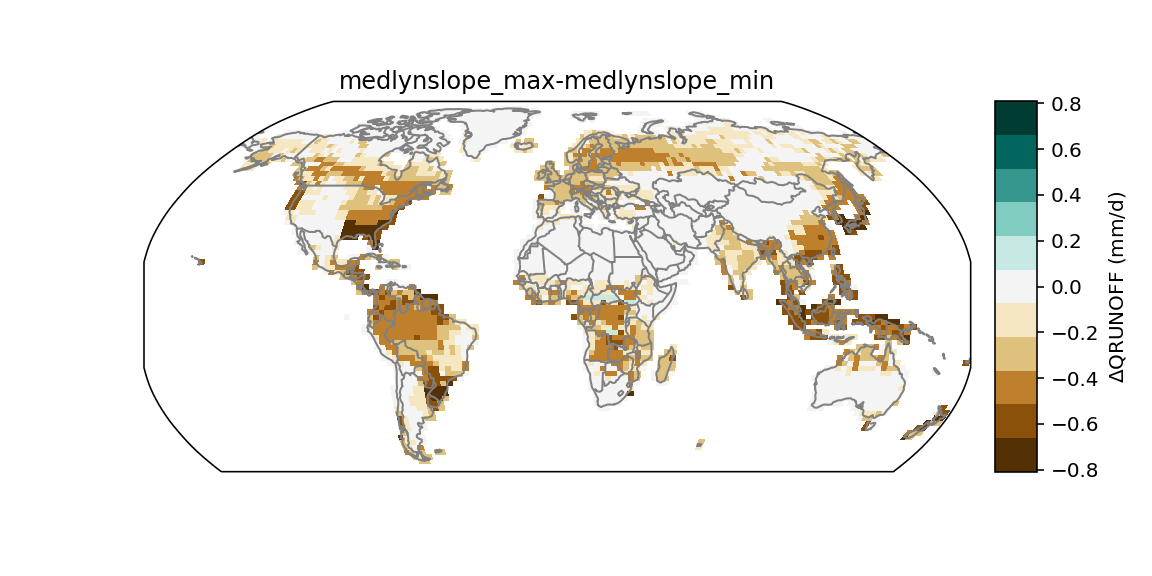

In [416]:
pane=pn.Row(obj.view,obj.param)
pane

In [391]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")
def make_colorbar(ax, mappable, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib as mpl

    divider = make_axes_locatable(ax)
    orientation = kwargs.pop('orientation', 'vertical')
    label = kwargs.pop('label',None)
    if orientation == 'vertical':
        loc = 'right'
    elif orientation == 'horizontal':
        loc = 'bottom'
        
    cax = divider.append_axes(loc, '5%', pad='3%', axes_class=mpl.pyplot.Axes)
    ax.get_figure().colorbar(mappable, cax=cax, orientation=orientation,label=label)

In [408]:
def deltmap(exp,v,p,u=None,cmap=brown_green()):
    das=find_pair(dsets[exp][v],ds.param,ds.minmax,p)
    xs=amean(das,cf=cfs[v]['cf1']).mean(dim='year')
    delt=(xs[1]-xs[0]).compute()
    dmap=get_map(delt)

    if not u:
        u=dsets['CTL2010'][v].attrs['units']
    if v=='QRUNOFF':
        u='mm/d'

    dmap.name=r'$\Delta$'+v+' ('+u+')'

    tstr=p+'_max-'+p+'_min'

    fig = plt.Figure(figsize=(8, 4))
    ax = fig.add_subplot(111,projection=ccrs.Robinson())
    ax.set_extent([-180, 180,-60,90], crs=ccrs.PlateCarree())
    
    mappable = dmap.plot(transform=ccrs.PlateCarree(),cmap=brown_green(),add_colorbar=False,ax=ax)
    ax.set_title(tstr)
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    ax.coastlines(color='grey')
    ax.add_feature(cfeature.BORDERS,edgecolor='grey')


    make_colorbar(ax,mappable,label=dmap.name)

    return fig

In [375]:
p='medlynslope'
exp='CTL2010'
v='QRUNOFF'

das=find_pair(dsets[exp][v],ds.param,ds.minmax,p)
xs=amean(das,cf=24*60*60).mean(dim='year')
dx=xs[1]-xs[0]
dxmap=get_map(dx)

In [381]:
dxmap=get_map(dx)

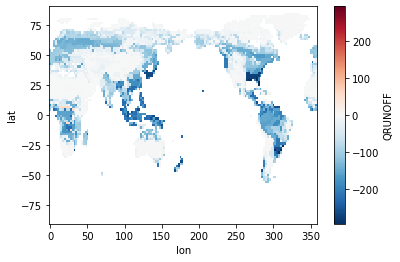

In [382]:
dxmap.plot()

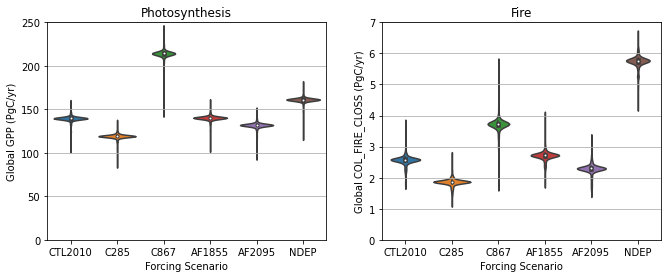

In [140]:
plt.figure(figsize=[11,4])
tts=['Photosynthesis','Fire']
for i,v in enumerate(['GPP','COL_FIRE_CLOSS']):
    
    x=xr.open_dataset('../data/'+v+'.nc')[v+'_glob_mean']
    x[4,58]=np.nan
    nens=len(x.ens)

    d={v:np.concatenate([x.sel(exp=exp).values for exp in exps]),
       'Experiment':np.repeat(exps,nens)}

    df=pd.DataFrame(d)
    
    plt.subplot(1,2,i+1)
    sns.violinplot(data=df,x='Experiment',y=v,orient='v')
    plt.ylim([0,250-243*(i==1)])
    plt.grid(axis='y')
    plt.ylabel('Global '+v+' (PgC/yr)')
    plt.xlabel('Forcing Scenario');
    plt.title(tts[i])
    #plt.savefig('../figs/gpp_violin.pdf',bbox_inches='tight');

In [94]:
v.shape

(2238,)

In [31]:
f,a,d=get_files('CTL2010',tape='h5')

In [35]:
ds1=get_exp('CTL2010',['QVEGT'],tape='h5')

In [65]:
(ds1.VPD.isel(gridcell=100)>0).sum()

<xarray.DataArray 'VPD' ()>
array(120)
Coordinates:
    gridcell  int64 100

In [77]:
v='EFLX_LH_TOT'
x=xr.open_dataset('../data/'+v+'.nc')[v+'_glob_mean']
x[:,58]=x[:,0]
xx=np.array([35,50])
dx=x.sel(exp='AF2095')/x.sel(exp='CTL2010')

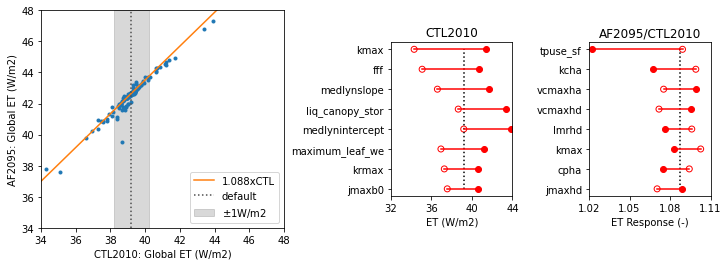

In [85]:
fig,axs=plt.subplot_mosaic('AFBBB;AFCGD;AFEEE',
                           figsize=[12,4],
                           gridspec_kw={'width_ratios': [4,1,2,0.5,2],'height_ratios': [1, 8,1]})
axs['B'].axis('off')
axs['E'].axis('off')
axs['F'].axis('off')
axs['G'].axis('off')

axs['A'].plot(x.sel(exp='CTL2010'),x.sel(exp='AF2095'),'.')
xx=np.array([34,48])
etp=np.round(dx.sel(ens=0).values,3)
axs['A'].plot(xx,etp*xx,label=str(etp)+'xCTL')
axs['A'].set_xlim(xx)
axs['A'].set_ylim(xx)

axs['A'].set_xlabel('CTL2010: Global ET (W/m2)')
axs['A'].set_ylabel('AF2095: Global ET (W/m2)')

xd=x.sel(ens=0,exp='CTL2010')
axs['A'].plot([xd,xd],[34,48],':',color=0.3*np.ones(3),label='default')
axs['A'].fill_between([xd-1,xd+1],[34,34],[48,48],color=0.5*np.ones(3),alpha=0.3,label=r'$\pm$1W/m2')
axs['A'].legend(loc=4)

rank_plot(x.sel(exp='CTL2010'),ds,8,ax=axs['C'])
axs['C'].set_xlim([32,44])
axs['C'].set_xticks(32+4*np.arange(4))
axs['C'].set_xlabel('ET (W/m2)')
axs['C'].set_title('CTL2010')
rank_plot(dx,ds,8,ax=axs['D'])
axs['D'].set_xlim([1.02,1.11])
axs['D'].set_xticks(1.02+0.03*np.arange(4))
axs['D'].set_xlabel('ET Response (-)')
axs['D'].set_title('AF2095/CTL2010');

plt.savefig('../figs/ET_response.pdf',bbox_inches='tight')

In [39]:
t=gmean(ds1.QVEGT,ds1.la)
vpd=gmean(ds1.VPD,ds1.la)

In [59]:
x=1/ds1.la.sum().values*np.nansum((ds1.la*ds1.VPD),axis=0)

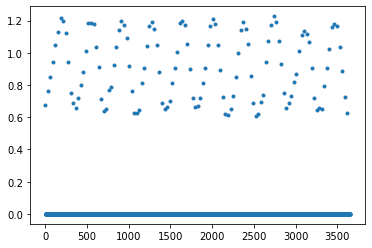

In [61]:
plt.plot(x,'.')

7.391771514754444e-09

In [52]:
x.shape

(3651,)

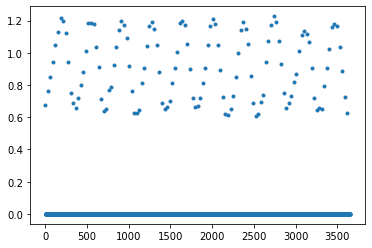

In [43]:
plt.plot(vpd,'.')

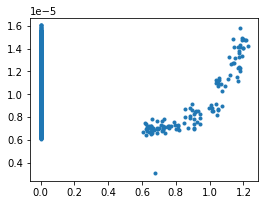

In [41]:
plt.figure(figsize=[9,3])
plt.subplot(121)
plt.plot(vpd,t.isel(ens=0),'.');

In [58]:
exps=['CTL2010','C285','C867','AF1855','AF2095','NDEP']
dvs=['TLAI','GPP','FCTR','SOILWATER_10CM']
dsets = {exp:get_exp(exp,dvs=dvs) for exp in exps}

120
120
120
120
120
120


In [68]:
#conversion factors
cfs={'PREC':{'cf1':24*60*60,'cf2':None},
     'GPP': {'cf1':24*60*60,'cf2':1e-9},
     'NBP': {'cf1':24*60*60,'cf2':1e-9},
     'FAREA_BURNED': {'cf1':24*60*60,'cf2':1}}
units={'PREC':'mm/d',
       'GPP':'PgC/yr',
       'NBP':'PgC/yr',
       'FAREA_BURNED':'km2'}
for v in ['FCTR','SOILWATER_10CM','TLAI']:
    cfs[v]={'cf1':1/365,'cf2':None}
    units[v]=dsets['CTL2010'][v].attrs['units']

In [72]:
la=dsets['CTL2010'].la
def agmean(exp,dv):
    return amean(gmean(dsets[exp][dv],la,cf=cfs[dv]['cf2']),cf=cfs[dv]['cf1']).mean(dim='year').compute()

In [74]:
%%time
expdim=xr.DataArray(exps,dims='exp')
ds=xr.Dataset(
    {dv:xr.concat([agmean(exp,dv) for exp in exps],dim=expdim) for dv in dvs}
    )
ds['param']=dsets['CTL2010'].param
ds['minmax']=dsets['CTL2010'].minmax

CPU times: user 51.4 s, sys: 2.09 s, total: 53.5 s
Wall time: 2min 12s


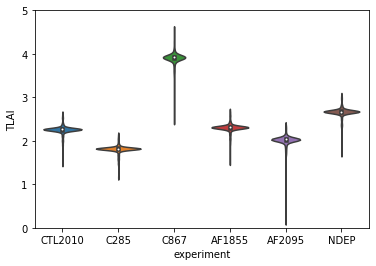

In [75]:
d={'TLAI':ds.TLAI.values.ravel(),
   'experiment':np.concatenate([np.tile(exp,len(ds.ens)) for exp in exps])}
df=pd.DataFrame(d)
sns.violinplot(data=df,x='experiment',y='TLAI')
plt.ylim([0,5]);

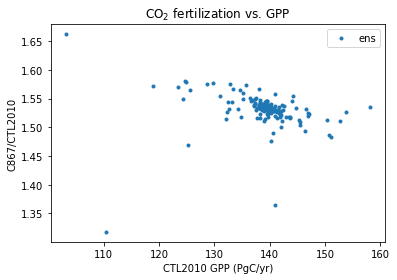

In [76]:
plt.plot(ds.GPP.sel(exp='CTL2010'),ds.GPP.sel(exp='C867')/ds.GPP.sel(exp='CTL2010'),'.',label='ens')
plt.xlabel('CTL2010 GPP (PgC/yr)')
plt.ylabel('C867/CTL2010')
plt.legend()
plt.title(r'CO$_2$ fertilization vs. GPP');

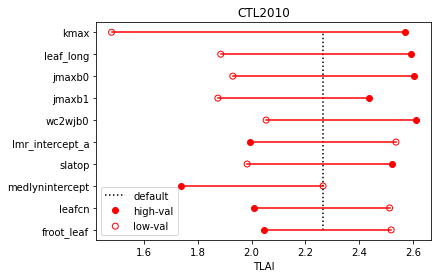

In [77]:
exp='CTL2010'
v='TLAI'
rank_plot(ds.TLAI.sel(exp=exp),ds,10)
plt.title(exp)
plt.xlabel('TLAI')
plt.legend(loc=3);

### OAAT: monthly h1 data

In [80]:
dvs=['TLAI']
ds=get_exp('CTL2010',dvs=dvs,tape='h1')

In [81]:
da=amean(ds.TLAI).mean(dim='year').compute()
dapft=gmean(da,ds.lapft,g=ds.pft)
ds=xr.Dataset()
ds['TLAI']=dapft
ds['param']=ds0.param
ds['minmax']=ds0.minmax
ds['pft_name']=ds0.pft_name

In [82]:
df=pd.DataFrame({'TLAI':dapft.values.T.ravel(),
    'pft':np.concatenate([np.tile(p,len(ds.ens)) for p in ds.pft_name.values])})

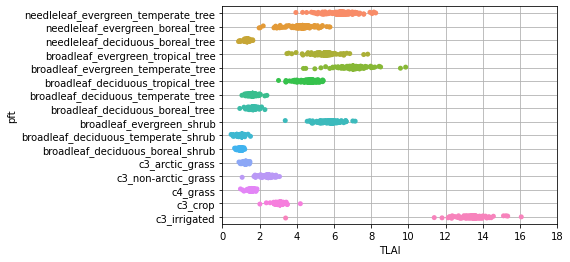

In [83]:
sns.stripplot(data=df,x='TLAI',y='pft')
plt.xlim([0,18])
plt.ylim([16.5,0.5])
plt.grid();

In [84]:
def rp(ds,p1,p2):
    
    fig = plt.Figure(figsize=[7,4])
    ax1=fig.add_subplot(121)
    ax2=fig.add_subplot(122)
    
    for p,ax in zip([p1,p2],[ax1,ax2]):
        da=ds.TLAI.sel(pft=p)
        rank_plot(da,ds,10,ax=ax)
        ax.set_title(ds.pft_name.sel(pft_id=p).values,fontsize=10)
        ax.set_xlabel('TLAI')
    
    fig.subplots_adjust(left=0.2,wspace=0.7)
    
    return fig

In [85]:
class Parameters(param.Parameterized):
    PFT1  = param.Integer(default=1, bounds=(1, 17))
    PFT2  = param.Integer(default=2, bounds=(1, 17))

    def view(self):
        return rp(ds,self.PFT1,self.PFT2)

obj = Parameters()
obj

Parameters(PFT1=1, PFT2=2, name='Parameters00101')

Row
    [0] ParamMethod(method)
    [1] Column(margin=5, name='Parameters', width=300)
        [0] StaticText(value='<b>Parameters</b>')
        [1] IntSlider(end=17, name='PFT1', start=1, value=1)
        [2] IntSlider(end=17, name='PFT2', start=1, value=2)
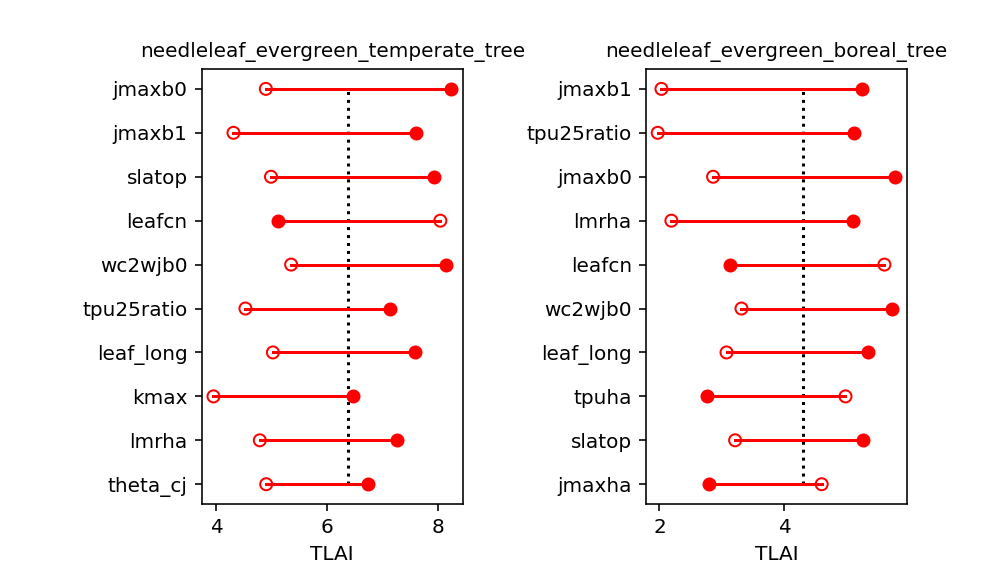

In [86]:
pn.Row(obj.view,obj.param)

### latin hypercube

In [300]:
ds=get_exp('transient',dvs=['TLAI'],yy=(2005,2014))

In [302]:
da=amean(gmean(ds.TLAI,ds.la)).mean(dim='year')

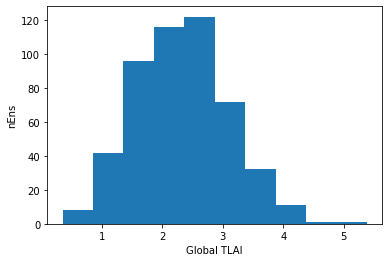

In [306]:
plt.hist(da)
plt.xlabel('Global TLAI')
plt.ylabel('nEns');